In [1]:
!nvidia-smi

Mon May 29 03:35:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import sys   

In [4]:
train_path = "/content/df_randomized_train.csv"
val_path = "/content/df_randomized_val.csv"

In [5]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

In [6]:
train_df.head()

,text,FriendsAndFamily,Professionals,RespectiveIndividuals,Strangers
0,gt And also have you ever became really clos...,1,0,0,0
1,Bristol Myers Squibb and Pfizer Receive Comp...,0,1,0,0
2,Our still has 13 days of safety,0,1,0,0
3,In more than than 1 200 be enter in activitie...,0,1,0,0
4,Pfizer Global Health Fellow Albert Dunne addre...,0,1,0,0


In [7]:
target_list = train_df.columns[1:].to_list()

In [8]:
target_list

['FriendsAndFamily', 'Professionals', 'RespectiveIndividuals', 'Strangers']

In [9]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-05

In [10]:
from transformers import BertTokenizer, BertModel

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [13]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [14]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
device

device(type='cuda')

In [17]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 4)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [19]:
train_losses = []
val_losses = []

In [20]:
def train_model(n_epochs, training_loader, validation_loader, model, optimizer):
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0
    total_training_batch = 0
    total_val_batch = 0
    model.train()
    print('Epoch {}:'.format(epoch), end='\t')
    for batch_idx, data in enumerate(training_loader):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total_training_batch += 1
    
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()
            total_val_batch += 1

    train_loss = train_loss/total_training_batch
    valid_loss = valid_loss/total_val_batch
  
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    if min(val_losses)==val_losses[-1]:
      torch.save(model.state_dict(), 'best_model.pth')

    print('Avgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format( train_loss, valid_loss))

  return model

In [21]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer)

Epoch 1:	Avgerage Training Loss: 0.276326 	Average Validation Loss: 0.203619
Epoch 2:	Avgerage Training Loss: 0.165239 	Average Validation Loss: 0.173876
Epoch 3:	Avgerage Training Loss: 0.128802 	Average Validation Loss: 0.176229
Epoch 4:	Avgerage Training Loss: 0.100447 	Average Validation Loss: 0.181389
Epoch 5:	Avgerage Training Loss: 0.071709 	Average Validation Loss: 0.202278


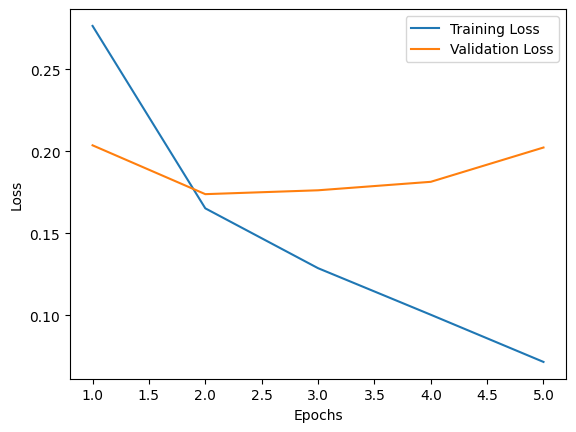

In [22]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there


Mounted at /content/drive


In [24]:
!cp /content/best_model.pth /content/drive/MyDrive/Datasets